In [114]:
import pandas as pd
import seaborn as sns
sns.set(style="ticks", palette="pastel")

In [115]:
DATA=pd.read_csv('Sample_0_200.csv')

In [116]:
DATA.columns

Index(['Unnamed: 0', 'titre', 'link', 'speech_type', 'prenom', 'nom', 'date',
       'theme', 'fonct', 'unique_id', 'MC1', 'MC2', 'MC3', 'MC4', 'MC5', 'MC6',
       'MC7', 'MC8', 'merge_id', 'discours', 'preusuel', 'sexe'],
      dtype='object')

In [117]:
DATA.shape

(347, 22)

In [118]:
theme_clean=[]
for theme in DATA.theme:
    if len(theme.split('\n'))==0:
        theme_clean.append(theme)
    if len(theme.split('\n'))>0:
        theme_clean.append(theme.split('\n')[0])
DATA.theme=theme_clean

# 1. Statistiques descriptives 

## Preprocess

In [119]:
# Pour l'instant on ne prend que les déclarations 
DATA=DATA[DATA.speech_type=='Déclaration']

In [120]:
# On ne s'intéresse pour l'instant qu'aux textes et au sexe 
DATA=DATA[['merge_id','discours','sexe']]
print('Shape data:', DATA.shape)

Shape data: (197, 3)


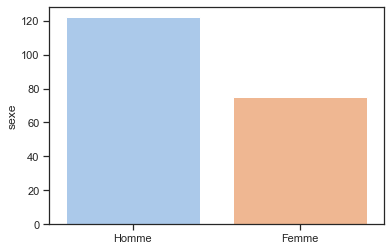

In [121]:
sns.barplot(x=['Homme','Femme'], y=DATA['sexe'].value_counts())
plt.show()
# Représentation plus importante des hommes (attendu). Il faudra voir comment prendre en compte la sur-représentation

In [54]:
# Enelever les premières phrase "Bonjour..." pour les interview et les madames monsieurs. 

In [55]:
import re
from tqdm import tqdm
import nltk 
from nltk import word_tokenize
from gensim import corpora
from gensim.models.phrases import Phrases, Phraser
from gensim.models import LdaModel
from collections import Counter
import matplotlib.pyplot as plt 
from string import punctuation
from nltk import pos_tag

In [56]:
import spacy
nlp = spacy.load("fr_core_news_sm")

## Sur l'ensemble du texte

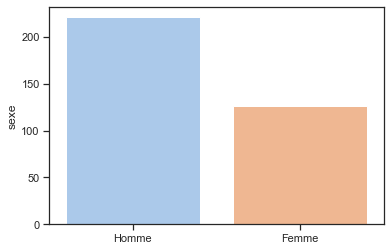

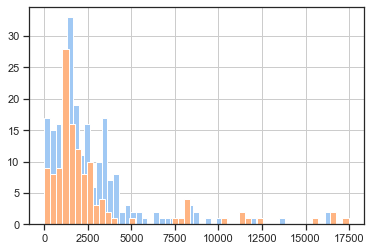

In [57]:
DATA['word_count'] = DATA['discours'].apply( lambda x : len(str(x).split(" ") ) )
DATA.word_count[DATA.sexe==1].hist(bins=50)
DATA.word_count[DATA.sexe==2].hist(bins=50)

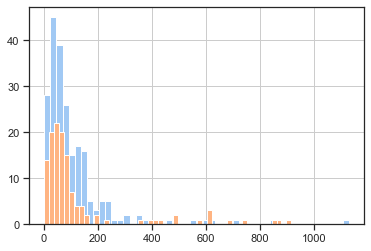

In [58]:
DATA['sent_count'] = DATA['discours'].apply( lambda x : len(str(x).split(".")))
DATA.sent_count[DATA.sexe==1].hist(bins=50)
DATA.sent_count[DATA.sexe==2].hist(bins=50)

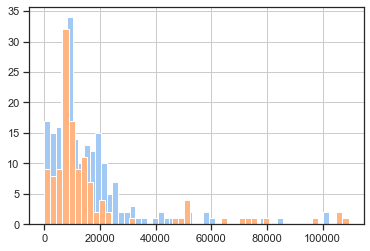

In [59]:
DATA['char_count'] = DATA['discours'].str.len() 
DATA.char_count[DATA.sexe==1].hist(bins=50)
DATA.char_count[DATA.sexe==2].hist(bins=50)

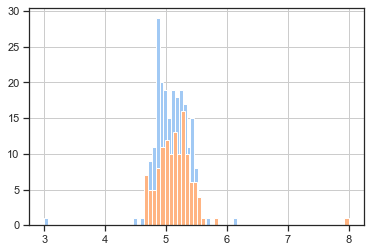

In [60]:
def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/len(words))

DATA['avg_word'] = DATA['discours'].apply(lambda x: avg_word(x))
DATA.avg_word[DATA.sexe==1].hist(bins=50)
DATA.avg_word[DATA.sexe==2].hist(bins=50)

In [61]:
from nltk.corpus import stopwords
en_stop = stopwords.words('french')

In [62]:
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('french'))
to_be_removed = list(en_stop) + list(punctuation) + list(('bonjour','m.','mme.'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\morga\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [66]:
DATA['discours_process']=DATA['discours'].apply(lambda x: " ".join(x.lower() for x in x.split()))
DATA['discours_process'] = DATA['discours_process'].str.replace('[^\w\s]','')
DATA['discours_process'] = DATA['discours_process'].str.replace('\x92',"'")
DATA['discours_process'] = DATA['discours_process'].str.replace(re.compile('[0-9]+'),"'")
DATA['discours_process'] = DATA['discours_process'].apply(lambda x: " ".join(x for x in x.split() if x not in to_be_removed))

In [67]:
freq_high = pd.Series(' '.join(DATA['discours_process']).split()).value_counts()[:10]
freq_high

cest     8429
a        7525
plus     4478
cette    3440
aussi    2889
donc     2624
tout     2484
ça       2398
très     2301
bien     2246
dtype: int64

In [16]:
#Non pas nécessaire !
#freq_high = list(freq_high.index)
#DATA['discours_process'] = DATA['discours_process'].apply(lambda x: " ".join(x for x in x.split() if x not in freq_high))

In [68]:
freq_low = pd.Series(' '.join(DATA['discours_process']).split()).value_counts()[-50:]
freq_low

retisser           1
douteux            1
cruciales          1
loiret             1
cautionnent        1
pouveznous         1
demmener           1
supplétives        1
paillettes         1
lenrichir          1
reconvoqué         1
shem               1
réformez           1
délaissée          1
résoudra           1
distend            1
désapprobation     1
zmoi               1
dangela            1
puzzle             1
each               1
prostituer         1
coordonnant        1
ass                1
donnezvous         1
dautorités         1
soigne             1
démence            1
débutent           1
explicites         1
oukases            1
léquipage          1
viceamiral         1
blog               1
dadministratif     1
soixantedixhuit    1
crous              1
entré              1
dissuadaient       1
satt               1
déléguons          1
condamnerai        1
protagonistes      1
contaminées        1
làpeuprès          1
caporaux           1
pratiquelà         1
linfirmier   

In [69]:
freq_low = list(freq_low.index)
DATA['discours_process'] = DATA['discours_process'].apply(lambda x: " ".join(x for x in x.split() if x not in freq_low))

In [70]:
from nltk.stem import PorterStemmer
st = PorterStemmer()
DATA['discours_process'][:5].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

0    marc fauvel oui bien sûr oui plaisir cest mome...
1    merci monsieur président cher bruno studer mer...
2    oui oui donc président républiqu loccas dy rev...
3    mesdam messieur parlementair mesdam messieur p...
4    cest vrai plaisir dêtre cet aprèsmidi devant p...
Name: discours_process, dtype: object

# Term frequency 

In [82]:
all_text = ' '.join([text for text in DATA['discours']])
print('Number of words in all_text:', len(all_text))

Number of words in all_text: 5690265


In [91]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
tfs = tfidf.fit_transform(DATA['discours_process'])

In [92]:
feature_names = tfidf.get_feature_names()
corpus_index = [n for n in list(tfidf.vocabulary_.keys())]
import pandas as pd
df = pd.DataFrame(tfs.todense(), columns=feature_names)
#print(df)

In [93]:
df

,__,aah,abad,abaissement,abaisser,abaisserons,abaissés,abandon,abandonne,abandonnent,...,îlots,ôter,ôté,ôtés,œur,œuvre,œuvrent,œuvres,œuvrez,œuvrons
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
344,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
345,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
import numpy as np

In [72]:
TF=(DATA['discours_process']).apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).reset_index()
TF.columns = ['words','tf']

In [45]:
from sklearn.feature_extraction.text import CountVectorizer
bow = CountVectorizer(max_features=1000, lowercase=True, ngram_range=(1,1),analyzer = "word")
train_bow = bow.fit_transform(DATA['discours_process'])

In [46]:
train_bow

<347x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 102097 stored elements in Compressed Sparse Row format>

# Prediction

In [ ]:
nlp = spacy.load("fr_core_news_sm")

In [ ]:
punctuations = string.punctuation

# Define function to cleanup text by removing personal pronouns, stopwords, and puncuation
def cleanup_text(docs, logging=False):
    texts = []
    counter = 1
    for doc in docs:
        if counter % 1000 == 0 and logging:
            print("Processed %d out of %d documents." % (counter, len(docs)))
        counter += 1
        doc = nlp(doc, disable=['parser', 'ner'])
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
        tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuations]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)

In [ ]:
from gensim.models.word2vec import Word2Vec

text_dim = 300

print("Training Word2Vec model...")

wordvec_model = Word2Vec(train_cleaned_word2vec, size=text_dim, window=5, min_count=3, workers=4, sg=1)

print("Word2Vec model created.")
print("%d unique words represented by %d dimensional vectors" % (len(wordvec_model.wv.vocab), text_dim))

In [ ]:
from sklearn.preprocessing import label_binarize

# Transform labels into one hot encoded format.
y_train_ohe = label_binarize(train['Author'], classes=['EAP', 'HPL', 'MWS'])
print('y_train_ohe shape: {}'.format(y_train_ohe.shape))
print('y_train_ohe samples:')
print(y_train_ohe[:5])

In [ ]:
from sklearn.model_selection import train_test_split

# If using spaCy word vectors
# X_train, X_test, y_train, y_test = train_test_split(train_vec, y_train_ohe, test_size=0.2, random_state=21)
# If using Word2Vec word vectors
X_train, X_test, y_train, y_test = train_test_split(train_cleaned_vec, y_train_ohe, test_size=0.2, random_state=21)

print('X_train size: {}'.format(X_train.shape))
print('X_test size: {}'.format(X_test.shape))
print('y_train size: {}'.format(y_train.shape))
print('y_test size: {}'.format(y_test.shape))

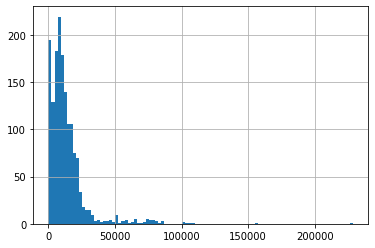

In [176]:
DATA.discours.apply(len).hist(bins=100)

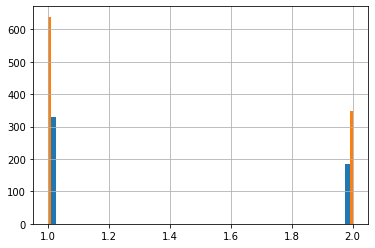

In [177]:
#Statistiques
#DATA.sexe.hist(bins=80) # 1 = Homme, 2 = Femme 
DATA[DATA.speech_type=='Interview'].sexe.hist(bins=40) 
DATA[DATA.speech_type=='Déclaration'].sexe.hist(bins=100) 

In [38]:
# Longueur interview ou discours
DATA.discours.apply(len).mean()

12063.23076923077

Tokenize 

In [184]:
import nltk
from gensim.models.phrases import Phrases, Phraser
from nltk.tokenize import word_tokenize
nltk.download('punkt')
sent_detector = nltk.data.load('tokenizers/punkt/french.pickle')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\morga\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [185]:
# Phrase 
import re
from tqdm import tqdm
import nltk 
from nltk import word_tokenize
from gensim import corpora
from gensim.models.phrases import Phrases, Phraser
from gensim.models import LdaModel
from collections import Counter
import matplotlib.pyplot as plt 
from string import punctuation
from nltk import pos_tag

nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('french'))
to_be_removed = list(en_stop) + list(punctuation) +['a','cette','ça','mme','mr','m.'] 

tokenized_sentences = []
for sample in tqdm(DATA.discours):
    for sentence in sent_detector.tokenize(sample):
        cleanr = re.compile('<.*?>')
        sentence = re.sub(cleanr, '', sentence)
        sentence= sentence.replace('\x92',"'")
        sentence = re.sub('[0-9]+', '', sentence)
        sentence=re.sub('\s+', ' ', sentence).strip()
        tokens = word_tokenize(sentence)
        tokens = list(map(lambda x: x.lower(), tokens))
        tokens=filter(lambda x: "http" not in x, tokens)
        tokens = [w for w in tokens if len(w) > 1 if not w in to_be_removed]
        tokenized_sentences+=tokens

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\morga\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 1567/1567 [00:38<00:00, 40.81it/s]


In [186]:
tokenized_sentences

['merci',
 'monsieur',
 'président',
 'cher',
 'bruno',
 'studer',
 'merci',
 'madame',
 'rapporteure',
 'générale',
 'chère',
 'aurore',
 'bergé',
 'merci',
 'aussi',
 'mesdames',
 'rapporteures',
 'chère',
 'sophie',
 'mette',
 'chère',
 'béatrice',
 'piron',
 'merci',
 'monsieur',
 'co-rapporteur',
 'cher',
 'jean-jacques',
 'gaultier',
 'différents',
 'rapporteurs',
 'avis',
 'bothorel',
 'portarrieu',
 'hennion',
 'euzet',
 'mesdames',
 'messieurs',
 'députés',
 'merci',
 'présence',
 'merci',
 'quelques',
 'heures',
 'allons',
 'passer',
 'ensemble',
 'tant',
 'commission',
 "l'hémicycle",
 'service',
 'projet',
 'loi',
 'si',
 'attendu',
 'si',
 'important',
 'si',
 'nécessaire',
 'aussi',
 'nécessaire',
 'parce',
 "l'heure",
 'où',
 'contenus',
 'abondent',
 'où',
 'modes',
 'visionnage',
 'diversifient',
 'où',
 'écrans',
 'démultiplient',
 'cadre',
 'législatif',
 'dépassé',
 'loi',
 'relative',
 'liberté',
 'communication',
 'date',
 "l'audiovisuel",
 "d'aujourd'hui",
 'plus

In [187]:
fd = nltk.FreqDist(tokenized_sentences)

In [188]:
vocab = nlargest(20, fd, key=fd.get)

NameError: name 'nlargest' is not defined

In [442]:
vocab

["c'est",
 'plus',
 'aussi',
 'donc',
 'tout',
 'bien',
 'faire',
 'très',
 "qu'il",
 'fait',
 'ministre',
 'france',
 'comme',
 'faut',
 'parce',
 'tous',
 'être',
 'président',
 "n'est",
 'si']

In [94]:
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en import LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES
import spacy
nlp = spacy.load("fr_core_news_sm")

In [194]:
# Instanciating lemmatizer
lemmatizer = Lemmatizer(LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES)
# Usage: lemmatizer(token, POS(token))
# But we will rather use spacy's nlp engine

# Counting lemmas vocabulary count
arr = DATA.discours.apply(lambda x: [w.lemma_ for w in nlp(x)]).array
arr = reduce(add, arr)
print("Number of unique lemmas found with Spacy's lemmatizer: {}".format(len(set(arr))))

lemmatization_sample =  DATA.discours.head().apply(lambda x: 
                                              [w.lemma_ for w in nlp(x)])
print("Lemmatization sample:\n {}".format(lemmatization_sample))

NameError: name 'Lemmatizer' is not defined

In [ ]:
from spacy import displacy

# Inspecting a dependency tree and it's POS TAGs wth displacy

doc=nlp(DATA.discours[0])
displacy.render(doc, style="ent",jupyter=True)

In [471]:
import spacy

nlp = spacy.load("fr_core_news_sm")
doc=nlp(DATA.discours[0])

for token in doc:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,token.shape_, token.is_alpha, token.is_stop)
    
pd.Dataframe()

Bonjour Bonjour PROPN PROPN___ ROOT Xxxxx True False


AttributeError: 'NoneType' object has no attribute 'pretty'

In [ ]:
from functools import reduce
from operator import add

arr = clean_corpus.apply(lambda x: list(filter(lambda a: a.lower() not in to_be_removed,word_tokenize(x)))).array
#Deja fit 
arr = reduce(add, np.array(arr))
c = Counter(np.array(arr))
print(c)
d = pd.DataFrame(c, index=['occurrences']).transpose().reset_index()
d.columns=['word', 'occurences']
nb_total = d.occurences.sum()
d['freq'] = d.occurences.apply(lambda x: x/nb_total)
d = d.sort_values('freq', ascending=False)

In [ ]:
arr=[]
for sentence in tokenized_sentences:
    arr+= sentence
arr

In [189]:
from gensim.models.phrases import Phrases, Phraser

def show_phrases(tokenized_sentences, threshold=10, shown=15):
    phrases = Phrases(tokenized_sentences, threshold=threshold)
    i = 0
    for phrase, score in phrases.export_phrases(tokenized_sentences):
        if i>shown:
            break
        else:
            print("Expression : {0}, score = {1}".format(phrase, score))
    i=i+1

In [190]:
show_phrases(tokenized_sentences,threshold=100)

In [191]:
phrases=Phrases(tokenized_sentences, threshold=80)

In [192]:
phraser = Phraser(phrases)
clean_corpus = []
for sentence in tokenized_sentences:
    clean_corpus.append(phraser[sentence])
  

In [193]:
from gensim.models import Word2Vec
from multiprocessing import cpu_count

cpu = cpu_count()
print('The virtual instance has {} cpus, that will be used to train the word2vec model'.format(cpu))

print("Training the political W2V ...")
pol = Word2Vec(clean_corpus, size=100, window=5, min_count=3, workers=cpu)
pol.train(clean_corpus, total_examples=len(clean_corpus), epochs=10)
pol_wv = pol.wv



The virtual instance has 8 cpus, that will be used to train the word2vec model
Training the political W2V ...


In [287]:
domains = ['politique'] 
wvs = [pol_wv]
def closest_to(w, n=10):
  for wv, domain in zip(wvs, domains):
    if w in wv:
      closest_ws =[w[0] for w in wv.most_similar(w, topn=n)]
      print("According to {}, the closest {}, words to \"{}\" " 
      "are: \n {}".format(domain, n, w, '"'+'",\n then "'.join(closest_ws)+'"'))
    else:
      print(w, " could not be found in the {} vocabulary".format(domain))

In [288]:
closest_to('économie')

According to politique, the closest 10, words to "économie" are: 
 "véritable",
 then "technologie",
 then "lasers",
 then "opérationnelle",
 then "environnementale",
 then "doter",
 then "culturelle",
 then "préservation",
 then "transformation",
 then "l'autonomie"


In [289]:
closest_to('finances')

According to politique, the closest 10, words to "finances" are: 
 "boukadoum",
 then "ministre_l'economie",
 then "adressée",
 then "l'intérieur",
 then "interrogée",
 then "ancien",
 then "laurent_saint-martin",
 then "confié",
 then "muriel_pénicaud",
 then "nicole_belloubet"


In [291]:
closest_to('environnement')

According to politique, the closest 10, words to "environnement" are: 
 "humain",
 then "cherchant",
 then "planification",
 then "autonome",
 then "préservation_biodiversité",
 then "productivité",
 then "ème_siècle",
 then "l'efficacité",
 then "alimentation",
 then "freiner"


In [293]:
closest_to('politique')

According to politique, the closest 10, words to "politique" are: 
 "ambitieuse",
 then "industrielle",
 then "stratégie",
 then "énergétique",
 then "agricole_commune",
 then "écologique",
 then "européenne",
 then "processus",
 then "vision",
 then "globale"


In [294]:
import os 

def save_embeddings(model, name):
    vocab_keys = list(model.wv.vocab.keys())
    vocab = {vocab_keys[i]: i for i in range(len(vocab_keys))}
    inv_vocab = {v: k for k, v in vocab.items()}
    METADATA_PATH = os.path.join('.', name+"_metadata.tsv")
    VECTOR_PATHS = os.path.join('.', name+"_embeddings.tsv")
    with open(METADATA_PATH, "w", encoding="utf-8") as metadata:
        with open(VECTOR_PATHS, "w", encoding="utf-8") as vectors:
            metadata.write("WORD\tINDEX\n")
            for i in tqdm(range(len(vocab))):
                try:
                    vector = model.wv[inv_vocab[i]]
                    metadata.write(
                        str(inv_vocab[i]) + "\t" + str(i) + "\n"
                    )
                    n = len(vector)
                    for j in range(n):
                        if j == (n - 1):
                            vectors.write(str(vector[j]) + "\n")
                        else:
                            vectors.write(str(vector[j]) + '\t')
                except:
                    print(
                        "{0} not in vocabulary. Passing. \n".format(
                            inv_vocab[i]
                        )
                    )
                    pass

In [295]:
save_embeddings(pol, "pol")

100%|██████████| 12871/12871 [00:01<00:00, 8722.35it/s]


In [696]:
from nltk.tokenize import ToktokTokenizer, word_tokenize
import nltk 
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
print(tokenizer.tokenize(DATA.discours[0]))


['Monsieur', 'le', 'vice', 'Président', 'du', 'Conseil', 'départemental', 'de', 'Mayotte']


In [697]:
# List of words with separator = " "
arr = DATA.discours.apply(lambda x: x.split(' ')).array

from functools import reduce
from operator import add

arr = reduce(add, arr) # Concatenates all lists contained in arr
# Equivalent to :
# arr2 = []
# for a in arr:
#   arr2 = arr2 + a
# arr = arr2
len(set(arr)) 
# the set object transforms a list to the set of unique elements in the list 

31464

In [698]:
from nltk.tokenize import ToktokTokenizer
from functools import reduce
from operator import add

arr = DATA.discours.apply(lambda x: tokenizer.tokenize(x)).array
arr = reduce(add, arr)

In [732]:
from collections import Counter
import matplotlib.pyplot as plt
from gensim.models import LdaModel
from gensim import corpora
import nltk
from string import punctuation

nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('french'))
to_be_removed = list(en_stop) + list(punctuation) +['a','cette','ça','Mme','Mr'] + list(str(x))

tok = tokenizer
arr = DATA[DATA.sexe==1].discours.apply(lambda x: list(filter(lambda a: a.lower() not in to_be_removed,tok.tokenize(x)))).array
arr = reduce(add, arr)
c = Counter(arr)
print(c)
d = pd.DataFrame(c, index=['occurrences']).transpose().reset_index()
d.columns=['word', 'occurences']
nb_total = d.occurences.sum()
d['freq'] = d.occurences.apply(lambda x: x/nb_total)
d = d.sort_values('freq', ascending=False)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\morga\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Counter({'plus': 1676, 'aussi': 1288, 'être': 1215, 'faire': 1048, 'tout': 957, 'très': 923, 'bien': 904, 'fait': 843, 'faut': 843, 'dire': 840, 'donc': 774, 'ministre': 750, 'France': 735, 'là': 729, 'parce': 721, 'hui': 718, 'comme': 700, 'tous': 672, 'aujourd': 641, 'peut': 626, 'si': 622, 'politique': 613, 'loi': 588, 'logement': 576, 'question': 562, 'beaucoup': 547, 'pense': 523, 'deux': 495, 'Europe': 477, 'pays': 475, 'Mme': 448, 'République': 437, 'va': 432, 'avoir': 432, 'quand': 428, 'où': 426, 'sans': 419, 'autres': 419, 'entre': 416, 'doit': 413, 'logements': 412, 'ailleurs': 409, 'ans': 406, 'fois': 399, 'président': 396, 'contre': 389, 'encore': 387, 'nombre': 379, 'ensemble': 378, 'dit': 367, 'crois': 366, 'travail': 365, 'sécurité': 365, 'dont': 362, 'ici': 356, 'ceux': 355, 'cela': 352, 'non': 337, 'sujet': 334, 'devons': 332, '000': 329, 'sociaux': 327, 'temps': 322, 'européenne': 318, 'Français': 318, 'notamment': 314, 'parole': 309, 'choses': 303, 'nationale': 301,

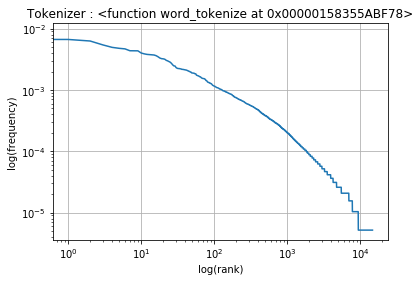

In [733]:
plt.figure()
plt.grid()
plt.xscale('log')  # Using log scale
plt.yscale('log')  # Using log scale
plt.xlabel('log(rank)')
plt.ylabel('log(frequency)')
plt.title("Tokenizer : {0}".format(word_tokenize))
x = list(range(d.shape[0]))
plt.plot(x, d.freq)
plt.show()

In [700]:
import nltk
import nltk.data
import re
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk import word_tokenize as wt
from spacy.tokenizer import Tokenizer
from spacy.lang.fr import French
nltk.download('stopwords')
french_stopwords = set(stopwords.words('french'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\morga\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [701]:
from spacy import displacy
nlp = French()


In [736]:
from gensim.models import LdaModel
from gensim import corpora
import nltk
from string import punctuation

nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('french'))
to_be_removed = list(en_stop) + list(punctuation)+ ['a','cette','ça','Mme','Mr']

tok = tokenizer
# Tokenizing + removing stopwords
text_data = list(DATA.discours.apply(lambda x: list(filter(lambda a: a.lower() not in to_be_removed,tok.tokenize(x)))).array)
def remove_url(tokens):
  tokens = filter(lambda x: "http" not in x, tokens)
  return list(tokens)
remove_url(text_data)
print(text_data[0])
dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]
ldamodel = LdaModel(corpus, id2word=dictionary, num_topics=5)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\morga\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['Monsieur', 'vice', 'Président', 'Conseil', 'départemental', 'Mayotte']


In [ ]:
!pip install pyLDAvis

In [737]:
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(lda_display)